# Load Data

In [1]:
import numpy as np
import torch
def set_seed(seed=0):
    """Sets seed"""
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed = 2
set_seed(seed=seed)

## Data: Waterbirds (Demo Example)

In [2]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_eval_loader
import torch
# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="waterbirds", 
                      root_dir="/root/MINE/waterbirds/",
                      download=True)
scale = 256.0/224.0
target_resolution=(224, 224)


train_dataset_img = dataset.get_subset(
    "train",
    transform= transforms.Compose(
         [transforms.Resize((int(target_resolution[0]*scale), int(target_resolution[1]*scale))),
         transforms.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.75, 4./3.),interpolation=2),
         transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
     ),
)

eval_dataset_img = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [
         transforms.Resize((int(target_resolution[0]*scale), int(target_resolution[1]*scale))),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    ),
)

test_dataset_img = dataset.get_subset(
    "test",
    transform=transforms.Compose(
        [transforms.Resize((int(target_resolution[0]*scale), int(target_resolution[1]*scale))),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    ),
)
batch_size = 16
# Prepare the standard data loader
train_loader_img = get_eval_loader("standard", train_dataset_img, batch_size=batch_size)
eval_loader_img = get_eval_loader("standard",eval_dataset_img, batch_size=batch_size)
test_loader_img = get_eval_loader("standard", test_dataset_img, batch_size=batch_size)
print('Done!')

Done!


/root/miniconda3/lib/python3.8/site-packages/torchvision/transforms/transforms.py:890: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


## Data: CMNIST

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import trange
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from torch.utils.data import Dataset, DataLoader

def color_grayscale_arr(arr, red=True):
    """Converts grayscale image to either red or green"""
    assert arr.ndim == 2
    dtype = arr.dtype
    h, w = arr.shape
    arr = np.reshape(arr, [h, w, 1])
    if red:
        arr = np.concatenate([arr, np.zeros((h, w, 2), dtype=dtype)], axis=2)
    else:
        arr = np.concatenate([np.zeros((h, w, 1), dtype=dtype), arr, np.zeros((h, w, 1), dtype=dtype)], axis=2)
    return arr

class ColoredMNIST(datasets.VisionDataset):
    """
    Colored MNIST dataset for testing IRM. Prepared using procedure from https://arxiv.org/pdf/1907.02893.pdf

    Args:
        root (string): Root directory of dataset where ``ColoredMNIST/*.pt`` will exist.
        env (string): Which environment to load. Must be 1 of 'train1', 'val', 'test', or 'all_train'.
        transform (callable, optional): A function/transform that takes in a PIL image and returns a transformed version.
        target_transform (callable, optional): A function/transform that takes in the target and transforms it.
    """
    def __init__(self, root='./MINE/data', env='train1', transform=None, target_transform=None):
        super(ColoredMNIST, self).__init__(root, transform=transform, target_transform=target_transform)
        self.prepare_colored_mnist()
        if env in ['train1', 'val', 'test']:
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', env) + '.pt')
        elif env == 'all_train':
            self.data_label_tuples = torch.load(os.path.join(self.root, 'ColoredMNIST', 'train1.pt')) + \
                                     torch.load(os.path.join(self.root, 'ColoredMNIST', 'val.pt'))
        else:
            raise RuntimeError(f'{env} env unknown. Valid envs are train1, val, test, and all_train')

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the index of the target class.
        """
        img, target, c = self.data_label_tuples[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, c

    def __len__(self):
        return len(self.data_label_tuples)

    def prepare_colored_mnist(self):
        colored_mnist_dir = os.path.join(self.root, 'ColoredMNIST')
        print('Preparing Colored MNIST')
        train_mnist = datasets.mnist.MNIST(self.root, train=True, download=True)

        train1_set = []
        val_set = []
        test_set = []
        for idx, (im, label) in enumerate(train_mnist):
            if idx % 10000 == 0:
                print(f'Converting image {idx}/{len(train_mnist)}')
            im_array = np.array(im)

            # Assign a binary label y to the image based on the digit
            binary_label = 0 if label < 5 else 1

            # Flip label with 25% probability
            if np.random.uniform() < 0.25:
                binary_label = binary_label ^ 1

            # Color the image either red or green according to its possibly flipped label
            color_red = binary_label == 0

            # Flip the color with a probability e that depends on the environment
            if idx < 30000:
                # 20% in the first training environment
                if np.random.uniform() < 0.2:
                    color_red = not color_red
            elif idx < 40000:
                # 10% in the first training environment
                if np.random.uniform() < 0.5:
                    color_red = not color_red
            else:
                # 90% in the test environment
                if np.random.uniform() < 0.9:
                    color_red = not color_red

            colored_arr = color_grayscale_arr(im_array, red=color_red)

            if idx < 30000:
                train1_set.append((Image.fromarray(colored_arr), binary_label, color_red))
            elif idx < 40000:
                val_set.append((Image.fromarray(colored_arr), binary_label, color_red))
            else:
                test_set.append((Image.fromarray(colored_arr), binary_label, color_red))
        random.shuffle(train1_set)
        random.shuffle(val_set)
        random.shuffle(test_set)
        if not os.path.exists(colored_mnist_dir):
            os.makedirs(colored_mnist_dir)
        torch.save(train1_set, os.path.join(colored_mnist_dir, 'train1.pt'))
        torch.save(val_set, os.path.join(colored_mnist_dir, 'val.pt'))
        torch.save(test_set, os.path.join(colored_mnist_dir, 'test.pt'))
        
train_dataset_img = ColoredMNIST(root='./MINE/data', env='train1',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                 ]))

train_loader_img = DataLoader(
    train_dataset_img,
    batch_size=batch_size, shuffle=False)

eval_dataset_img = ColoredMNIST(root='./MINE/data', env='val',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                 ]))

eval_loader_img = DataLoader(
    eval_dataset_img,
    batch_size=batch_size, shuffle=False)

test_dataset_img = ColoredMNIST(root='./MINE/data', env='test',
                 transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.1307, 0.1307, 0.), (0.3081, 0.3081, 0.3081))
                 ]))

test_loader_img = DataLoader(
    test_dataset_img,
    batch_size=batch_size, shuffle=False)

## Data: MNIST-FashionMNIST

In [ ]:
import torch
from torchvision import transforms
from tqdm import tqdm  
from torch.utils.data import Dataset
import numpy as np
def create_custom_dataset(mydataset,test=False):
    class CustomDataset(Dataset):
        def __init__(self, data, targets):
            self.data = data
            self.targets = targets

        def __getitem__(self, index):
            return self.data[index], self.targets[index]

        def __len__(self):
            return len(self.data)

    if not test:
        data = mydataset.dataset.data[mydataset.indices].unsqueeze(1).repeat(1, 3, 1, 1)
        targets = mydataset.dataset.targets[mydataset.indices]
    else:
        data = mydataset.data.unsqueeze(1).repeat(1, 3, 1, 1)
        targets = mydataset.targets
    custom_dataset = CustomDataset(data, targets)

    return custom_dataset

def create_combined_dataset(fashionmnist_dataset, mnist_dataset, ratio_1, ratio_2,batch_size = 64):
    combined_dataset = []

    for i in tqdm(range(len(fashionmnist_dataset)), desc='Matching Progress'):
        fashionmnist_image, fashionmnist_label = fashionmnist_dataset[i]
        if fashionmnist_label == 3:
            fashionmnist_label = torch.tensor(0)
            a = torch.tensor(1) if torch.rand(1) < ratio_1 else torch.tensor(0)
            mnist_labels = mnist_dataset.targets == a
            matching_mnist_images = mnist_dataset.data[mnist_labels]
            num_matching_mnist_images = len(matching_mnist_images)

            if num_matching_mnist_images == 0:
                print('No Matching')
                continue

            random_index = torch.randint(0, num_matching_mnist_images, (1,)).item()
            mnist_image = transforms.ToTensor()(transforms.ToPILImage()(matching_mnist_images[random_index]))
            mnist_label = a
            fashionmnist_image = transforms.ToTensor()(transforms.ToPILImage()(fashionmnist_image))
            combined_image = torch.cat((mnist_image, fashionmnist_image), dim=1)

            combined_dataset.append((combined_image, fashionmnist_label, mnist_label))
        elif fashionmnist_label == 4:
            fashionmnist_label = torch.tensor(1)
            a = torch.tensor(1) if torch.rand(1) < ratio_2 else torch.tensor(0)
            mnist_labels = mnist_dataset.targets == a
            matching_mnist_images = mnist_dataset.data[mnist_labels]
            num_matching_mnist_images = len(matching_mnist_images)

            if num_matching_mnist_images == 0:
                print('No Matching')
                continue

            random_index = torch.randint(0, num_matching_mnist_images, (1,)).item()
            mnist_image = transforms.ToTensor()(transforms.ToPILImage()(matching_mnist_images[random_index]))
            mnist_label = a
            fashionmnist_image = transforms.ToTensor()(transforms.ToPILImage()(fashionmnist_image))

            combined_image = torch.cat((mnist_image, fashionmnist_image), dim=1)

            combined_dataset.append((combined_image, fashionmnist_label, mnist_label))
    
    print('Creating DataLoader')
    samples = torch.stack([sample[0] for sample in combined_dataset])
    labels = torch.tensor([sample[1] for sample in combined_dataset])
    spuriou_labels = torch.tensor([sample[2] for sample in combined_dataset])
    combined_tensor_dataset = TensorDataset(samples, labels,spuriou_labels)
    data_loader = DataLoader(combined_tensor_dataset, batch_size=batch_size, shuffle=False)
    print('Done')

    return data_loader,combined_dataset


In [ ]:
from torchvision import datasets
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

class MNISTToRGB(object):
    def __call__(self, image):
        # Create an empty tensor with three channels
        rgb_image = torch.empty(3, image.shape[1], image.shape[2])
        
        # Fill all three channels with the grayscale image
        rgb_image[0] = image
        rgb_image[1] = image
        rgb_image[2] = image
        
        return rgb_image
    
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081, ))
])

fashionmnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])


mnist_dataset = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
fashionmnist_dataset = datasets.FashionMNIST(root='./data', train=True, transform=fashionmnist_transform, download=True)

# Train & Eval
train_ratio = 0.9  
train_size = int(len(mnist_dataset) * train_ratio)
valid_size = len(mnist_dataset) - train_size
mnist_train_dataset, mnist_eval_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, valid_size])

train_size = int(len(fashionmnist_dataset) * train_ratio)
valid_size = len(fashionmnist_dataset) - train_size
fashionmnist_train_dataset, fashionmnist_eval_dataset = torch.utils.data.random_split(fashionmnist_dataset, [train_size, valid_size])


# Train
mnist_train_dataset = create_custom_dataset(mnist_train_dataset)
fashionmnist_train_dataset = create_custom_dataset(fashionmnist_train_dataset)

# Eval
mnist_eval_dataset = create_custom_dataset(mnist_eval_dataset)
fashionmnist_eval_dataset = create_custom_dataset(fashionmnist_eval_dataset)

# Test
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=mnist_transform, download=True)
fashionmnist_test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=fashionmnist_transform, download=True)
mnist_test_dataset = create_custom_dataset(mnist_test_dataset,test=True)
fashionmnist_test_dataset = create_custom_dataset(fashionmnist_test_dataset,test=True)


In [ ]:
batch_size = 32
train_loader_img,_ = create_combined_dataset(fashionmnist_train_dataset, mnist_train_dataset, ratio_1=0.1, ratio_2=0.9,batch_size = batch_size)
eval_loader_img,_ = create_combined_dataset(fashionmnist_eval_dataset, mnist_eval_dataset, ratio_1=0.3, ratio_2=0.7,batch_size = batch_size)
test_loader_img,_ = create_combined_dataset(fashionmnist_test_dataset, mnist_test_dataset, ratio_1=0.95, ratio_2=0.05,batch_size = batch_size)

## Data: MNIST-CIFAR

In [ ]:
import torch
from torchvision import transforms
from tqdm import tqdm  
from torch.utils.data import Dataset
import numpy as np


def set_seed(seed=0):
    """Sets seed"""
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def create_custom_dataset(mydataset,test=False):
    class CustomDataset(Dataset):
        def __init__(self, data, targets):
            self.data = data
            self.targets = targets

        def __getitem__(self, index):
            return self.data[index], self.targets[index]

        def __len__(self):
            return len(self.data)

    if not test:
        if len(mydataset.dataset.data.shape)!=4:
            data = mydataset.dataset.data[mydataset.indices].unsqueeze(1).repeat(1, 3, 1, 1)
        else:
            data = mydataset.dataset.data[mydataset.indices]
        targets = torch.tensor(mydataset.dataset.targets)[mydataset.indices]
    else:
        if len(mydataset.data.shape)!=4:
            data = mydataset.data.unsqueeze(1).repeat(1, 3, 1, 1)
        else:
            data = mydataset.data#.unsqueeze(1).repeat(1, 3, 1, 1)
        targets = mydataset.targets
    custom_dataset = CustomDataset(data, targets)

    return custom_dataset

def create_combined_dataset(fashionmnist_dataset, mnist_dataset, ratio_1, ratio_2,batch_size = 64):
    combined_dataset = []

    for i in tqdm(range(len(fashionmnist_dataset)), desc='Matching Progress'):
        fashionmnist_image, fashionmnist_label = fashionmnist_dataset[i]
        if fashionmnist_label <= 4:
            fashionmnist_label = torch.tensor(0)
            a = torch.tensor(1) if torch.rand(1) < ratio_1 else torch.tensor(0)
            mnist_labels = mnist_dataset.targets == a
            matching_mnist_images = mnist_dataset.data[mnist_labels]
            num_matching_mnist_images = len(matching_mnist_images)

            if num_matching_mnist_images == 0:
                print('No Matching')
                continue

            random_index = torch.randint(0, num_matching_mnist_images, (1,)).item()
            mnist_image = transforms.ToTensor()(transforms.ToPILImage()(matching_mnist_images[random_index]))
            mnist_label = a
            fashionmnist_image = transforms.ToTensor()(transforms.ToPILImage()(fashionmnist_image))
            # print('mnist_image1:',mnist_image.shape,'fashionmnist_image:',fashionmnist_image.shape)
            combined_image = torch.cat((mnist_image, fashionmnist_image), dim=1)

            combined_dataset.append((combined_image, fashionmnist_label, mnist_label))
        elif fashionmnist_label > 4:
            fashionmnist_label = torch.tensor(1)
            a = torch.tensor(1) if torch.rand(1) < ratio_2 else torch.tensor(0)
            mnist_labels = mnist_dataset.targets == a
            matching_mnist_images = mnist_dataset.data[mnist_labels]
            num_matching_mnist_images = len(matching_mnist_images)

            if num_matching_mnist_images == 0:
                print('No Matching')
                continue

            random_index = torch.randint(0, num_matching_mnist_images, (1,)).item()
            mnist_image = transforms.ToTensor()(transforms.ToPILImage()(matching_mnist_images[random_index]))
            mnist_label = a
            fashionmnist_image = transforms.ToTensor()(transforms.ToPILImage()(fashionmnist_image))

            combined_image = torch.cat((mnist_image, fashionmnist_image), dim=1)

            combined_dataset.append((combined_image, fashionmnist_label, mnist_label))
    
    print('Creating DataLoader')
    samples = torch.stack([sample[0] for sample in combined_dataset])
    labels = torch.tensor([sample[1] for sample in combined_dataset])
    spuriou_labels = torch.tensor([sample[2] for sample in combined_dataset])
    combined_tensor_dataset = TensorDataset(samples, labels,spuriou_labels)
    data_loader = DataLoader(combined_tensor_dataset, batch_size=batch_size, shuffle=False)
    print('Done')

    return data_loader,combined_dataset


In [ ]:
from torchvision import datasets
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

class MNISTToRGB(object):
    def __call__(self, image):
        # Create an empty tensor with three channels
        rgb_image = torch.empty(3, image.shape[1], image.shape[2])
        
        # Fill all three channels with the grayscale image
        rgb_image[0] = image
        rgb_image[1] = image
        rgb_image[2] = image
        
        return rgb_image
    
mnist_transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081, ))
])

fashionmnist_transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


mnist_dataset = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
fashionmnist_dataset = datasets.CIFAR10(root='./data', train=True, transform=fashionmnist_transform, download=True)
fashionmnist_dataset.data = fashionmnist_dataset.data[:, :28, :28]
# Train & Eval
train_ratio = 0.9  
train_size = int(len(mnist_dataset) * train_ratio)
valid_size = len(mnist_dataset) - train_size
mnist_train_dataset, mnist_eval_dataset = torch.utils.data.random_split(mnist_dataset, [train_size, valid_size])

train_size = int(len(fashionmnist_dataset) * train_ratio)
valid_size = len(fashionmnist_dataset) - train_size
fashionmnist_train_dataset, fashionmnist_eval_dataset = torch.utils.data.random_split(fashionmnist_dataset, [train_size, valid_size])


# Train
mnist_train_dataset = create_custom_dataset(mnist_train_dataset)
fashionmnist_train_dataset = create_custom_dataset(fashionmnist_train_dataset)

# Eval
mnist_eval_dataset = create_custom_dataset(mnist_eval_dataset)
fashionmnist_eval_dataset = create_custom_dataset(fashionmnist_eval_dataset)

# Test
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=mnist_transform, download=True)
fashionmnist_test_dataset = datasets.CIFAR10(root='./data', train=False, transform=fashionmnist_transform, download=True)
fashionmnist_test_dataset.data = fashionmnist_test_dataset.data[:, :28, :28]
mnist_test_dataset = create_custom_dataset(mnist_test_dataset,test=True)
fashionmnist_test_dataset = create_custom_dataset(fashionmnist_test_dataset,test=True)


In [ ]:
batch_size = 32
train_loader_img,_ = create_combined_dataset(fashionmnist_train_dataset, mnist_train_dataset, ratio_1=0.01, ratio_2=0.99,batch_size = batch_size)
eval_loader_img,_ = create_combined_dataset(fashionmnist_eval_dataset, mnist_eval_dataset, ratio_1=0.3, ratio_2=0.7,batch_size = batch_size)
test_loader_img,_ = create_combined_dataset(fashionmnist_test_dataset, mnist_test_dataset, ratio_1=0.9, ratio_2=0.1,batch_size = batch_size)

## Data: CelebA

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import numpy as np
from PIL import Image
from tqdm import trange
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
import torchvision.transforms as transforms
from wilds.common.data_loaders import get_eval_loader
# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="celebA", 
                      root_dir="/root/MINE/celebA/",
                      download=True)


# Get the training set
train_dataset_img = dataset.get_subset(
    "train",
    transform=transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    ),
)

eval_dataset_img = dataset.get_subset(
    "val",
    transform=transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    ),
)

test_dataset_img = dataset.get_subset(
    "test",
    transform=transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
    ),
)

batch_size=16

# Prepare the standard data loader
train_loader_img = get_eval_loader("standard", train_dataset_img, batch_size=batch_size)
print(f"train loader size: {len(train_loader_img)}")
eval_loader_img = get_eval_loader("standard",eval_dataset_img, batch_size=batch_size)
test_loader_img = get_eval_loader("standard", test_dataset_img, batch_size=batch_size)
print('Done!')

## Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4795
The selected random index is: 3791
tensor(0) tensor([0, 0, 1])


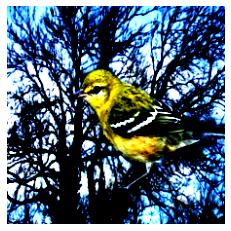

In [3]:
import torch
import matplotlib.pyplot as plt
import random
print(len(train_loader_img.dataset))
k = random.randint(1, len(train_loader_img.dataset))
print("The selected random index is:", k)
image = train_loader_img.dataset[k][0]
print(train_loader_img.dataset[k][1],train_loader_img.dataset[k][2])
image = image.numpy()
plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')
plt.show()

## Statistics Info

In [ ]:
import numpy as np
total_samples = len(train_loader_img.dataset)
landbird_on_land_count = 0
landbird_on_water_count = 0
waterbird_on_land_count = 0
waterbird_on_water_count = 0
y_true_0 = []
background_0 = []
y_true_1 = []
background_1 = []

for batch in train_loader_img:
    x,y_true,background = batch
    for i in range(len(y_true)):
        if y_true[i].item() == 0 and background[i][0].item() == 0:
            landbird_on_land_count += 1
            y_true_0.append(y_true)
            background_0.append(background)
        elif y_true[i].item() == 0 and background[i][0].item() == 1:
            landbird_on_water_count += 1
            y_true_1.append(y_true)
            background_1.append(background)
        elif y_true[i].item() == 1 and background[i][0].item() == 0:
            waterbird_on_land_count += 1
            y_true_0.append(y_true)
            background_0.append(background)
        elif y_true[i].item() == 1 and background[i][0].item() == 1:
            waterbird_on_water_count += 1
            y_true_1.append(y_true)
            background_1.append(background)

landbird_on_land_ratio = landbird_on_land_count / total_samples
landbird_on_water_ratio = landbird_on_water_count / total_samples
waterbird_on_land_ratio = waterbird_on_land_count / total_samples
waterbird_on_water_ratio = waterbird_on_water_count / total_samples
print("landbird_on_land and landbird_on_land_count:", landbird_on_land_ratio,landbird_on_land_count)
print("landbird_on_water_ratio and landbird_on_water_count:", landbird_on_water_ratio,landbird_on_water_count)
print("waterbird_on_land_ratio and waterbird_on_land_count:", waterbird_on_land_ratio,waterbird_on_land_count)
print("waterbird_on_water_ratio and waterbird_on_water_count:", waterbird_on_water_ratio,waterbird_on_water_count)
print("landbird_on_land / landbird:", landbird_on_land_count/(landbird_on_land_count+landbird_on_water_count))
print("waterbird_on_land / waterbird:", waterbird_on_land_count/(waterbird_on_land_count+waterbird_on_water_count))

landbird_on_land and landbird_on_land_count: 0.7295099061522419 3498
landbird_on_water_ratio and landbird_on_water_count: 0.0383733055265902 184
waterbird_on_land_ratio and waterbird_on_land_count: 0.01167883211678832 56
waterbird_on_water_ratio and waterbird_on_water_count: 0.22043795620437956 1057
landbird_on_land / landbird: 0.9500271591526345
waterbird_on_land / waterbird: 0.050314465408805034


# Vanilla

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import numpy as np
from PIL import Image
from tqdm import trange
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from torch.optim.lr_scheduler import CosineAnnealingLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class ResNet(nn.Module):
    def __init__(self, hidden_num=16 ,num_classes=1):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x
    

def train(model, train_loader,test_loader ,criterion, optimizer, epochs):
    model.train()
    predictions = []
    acc = 0
    total = 0
    for epoch in range(epochs):
        running_loss = 0.0
        # for inputs, labels,_ in train_loader:
        for (inputs, labels,_), (inputs_test, labels_test,_) in zip(train_loader, test_loader):
            optimizer.zero_grad()
            inputs, labels=inputs.to(device),labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.float().view(-1, 1))  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            inputs_test=inputs_test.to(device)
            labels_test=labels_test.to(device)
            outputs_test = model(inputs_test)
            predicted_labels = torch.squeeze(torch.round(outputs_test))  
            predictions.extend(predicted_labels.tolist())
            acc += (predicted_labels == labels_test).sum().item()
            total += labels_test.size(0)
            running_loss += loss.item()
        
        print('Epoch [%d/%d], Loss: %.4f, Eval ACC: %.4f' % (epoch+1, epochs, running_loss,acc/total))

def predict_acc(model, test_loader):
    model.eval()
    predictions = []
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels,_ in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.squeeze(torch.round(outputs))
            predictions.extend(predicted.tolist())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy,predictions

cuda


In [7]:
torch.manual_seed(seed)
model =  ResNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)
train(model, train_loader_img,eval_loader_img, criterion, optimizer, epochs=300)

Epoch [1/300], Loss: 43.0444, Eval ACC: 0.6856
Epoch [2/300], Loss: 44.1960, Eval ACC: 0.6856
Epoch [3/300], Loss: 44.0095, Eval ACC: 0.6878
Epoch [4/300], Loss: 43.8056, Eval ACC: 0.6897
Epoch [5/300], Loss: 43.7062, Eval ACC: 0.6911
Epoch [6/300], Loss: 43.4184, Eval ACC: 0.6920
Epoch [7/300], Loss: 43.2543, Eval ACC: 0.6927
Epoch [8/300], Loss: 43.1547, Eval ACC: 0.6938
Epoch [9/300], Loss: 43.0282, Eval ACC: 0.6948
Epoch [10/300], Loss: 43.1064, Eval ACC: 0.6960
Epoch [11/300], Loss: 42.9216, Eval ACC: 0.6969
Epoch [12/300], Loss: 42.7060, Eval ACC: 0.6978
Epoch [13/300], Loss: 42.6783, Eval ACC: 0.6986
Epoch [14/300], Loss: 42.6635, Eval ACC: 0.6993
Epoch [15/300], Loss: 42.6235, Eval ACC: 0.7000
Epoch [16/300], Loss: 42.5324, Eval ACC: 0.7005
Epoch [17/300], Loss: 42.4974, Eval ACC: 0.7008
Epoch [18/300], Loss: 42.3295, Eval ACC: 0.7011
Epoch [19/300], Loss: 42.4368, Eval ACC: 0.7014
Epoch [20/300], Loss: 42.1678, Eval ACC: 0.7018
Epoch [21/300], Loss: 42.1833, Eval ACC: 0.7020
E

## Mean ACC

In [8]:
train_acc,vanilla_label_train=predict_acc(model, train_loader_img)
print('Accuracy on train_loader_img: {:.2f}%'.format(train_acc))

eval_acc,_=predict_acc(model, eval_loader_img)
print('Accuracy on eval_loader_img: {:.2f}%'.format(eval_acc))

test_acc,_=predict_acc(model, test_loader_img)
print('Accuracy on test_loader_img: {:.2f}%'.format(test_acc))

Accuracy on train_loader_img: 88.45%
Accuracy on eval_loader_img: 66.81%
Accuracy on test_loader_img: 67.66%


## Worst ACC

In [10]:
import torch
from torch.utils.data import Subset, DataLoader
batch_size = 128
spurious_indices = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label != color_red[0]]
subset_dataset = Subset(train_loader_img.dataset, spurious_indices)
worst_train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_train_acc,worst_vanilla_label_train=predict_acc(model, worst_train_loader)
print('Train Accuracy of Worst Group:', worst_train_acc)

spurious_indices = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label != color_red[0]]
subset_dataset = Subset(eval_loader_img.dataset, spurious_indices)
worst_eval_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_eval_acc,worst_vanilla_label_eval=predict_acc(model, worst_eval_loader)
print('Eval Accuracy of Worst Group:', worst_eval_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label != color_red[0]]
subset_dataset = Subset(test_loader_img.dataset, spurious_indices)
worst_test_loader = DataLoader(subset_dataset, batch_size= batch_size, shuffle=True)
worst_test_acc,worst_vanilla_label_test=predict_acc(model, worst_test_loader)
print('Test Accuracy of Worst Group:', worst_test_acc)
batch_size = 16

Train Accuracy of Worst Group: 45.416666666666664
Eval Accuracy of Worst Group: 42.07011686143573
Test Accuracy of Worst Group: 44.183638246461854


# Mixup

In [11]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Subset, DataLoader, random_split
import pandas as pd

# same label different domain
def mixup_strategy1(B1_input, B1_target1, B1_target2, B1_colors):
    B2_input = []
    B2_target = []
    right = 0

    for inputs, target1,target2, colors in zip(B1_input, B1_target1, B1_target2, B1_colors):
        indices=torch.where((train_labels == target1.item()) & (DISK_labels != target2.item()))[0].tolist()
        
        selected_index = indices[torch.randint(len(indices), size=(1,))]
        selected_data = combined_loader_img.dataset[selected_index]
        selected_sample = selected_data[0][0]
        selected_target = selected_data[0][1]
        selected_colors = selected_data[0][2][0]

        selected_sample =selected_sample.to(device)
        selected_target =selected_target.to(device)
        B2_input.append(selected_sample)
        B2_target.append(selected_target)
        
        if colors.item() == selected_colors.item():
            right +=1
            # print('Selected Index:',indices[selected_index],'target2:', target2.item(), 'colors:', colors.item(), 'B1_colors', selected_colors.item())

    return torch.stack(B2_input), torch.stack(B2_target), right

# same domain different label
def mixup_strategy2(B1_input, B1_target1, B1_target2, B1_colors):
    B2_input = []
    B2_target = []
    right = 0

    for inputs, target1,target2,colors in zip(B1_input, B1_target1, B1_target2, B1_colors):
        indices=torch.where((train_labels != target1.item()) & (DISK_labels == target2.item()))[0].tolist()
        selected_index = indices[torch.randint(len(indices), size=(1,))]
        selected_data = combined_loader_img.dataset[selected_index]
        selected_sample = selected_data[0][0]
        selected_target = selected_data[0][1]
        selected_colors = selected_data[0][2][0]
        selected_sample =selected_sample.to(device)
        selected_target =selected_target.to(device)

        B2_input.append(selected_sample)
        B2_target.append(selected_target)
        
        
        if colors.item() != selected_colors.item():
            right +=1
    return torch.stack(B2_input), torch.stack(B2_target), right

def train_mixup(model, train_loader, criterion, optimizer, epochs,alpha=2,p=0.5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        count=0
        all_batches=0
        all_errors=0
        for (B1_input, B1_target1, B1_colors), B1_target2 in train_loader:
            optimizer.zero_grad()
            B1_colors = B1_colors[:,0]
            B1_target2 = B1_target2[0]
            count+=1
            B1_input=B1_input.to(device)
            B1_target1=B1_target1.to(device)
            B1_target2=B1_target2.to(device)
            lambdas = torch.distributions.beta.Beta(alpha, alpha).sample()  
            B2_input = torch.empty_like(B1_input)
            B2_target = torch.empty_like(B1_target1)
            all_batches+= len(B1_target2)
            S = torch.bernoulli(torch.tensor(p))  
            
            if S == 1:
                B2_input, B2_target,errors = mixup_strategy1(B1_input, B1_target1, B1_target2, B1_colors)
            else:
                B2_input, B2_target,errors = mixup_strategy2(B1_input, B1_target1, B1_target2, B1_colors)

            mixed_input = lambdas * B1_input + (1 - lambdas) * B2_input
            mixed_target = lambdas * B1_target1 + (1 - lambdas) * B2_target
            all_errors += errors
            outputs = model(mixed_input)
            loss = criterion(outputs, mixed_target.float().view(-1, 1))  
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print('Epoch [%d/%d], Loss: %.4f, Matching Errors: %.4f, All Batch: %.0f' % (epoch+1, epochs, running_loss, all_errors/all_batches,all_batches))


def predict_acc(model, test_loader):
    model.eval()
    predictions = []
    acc = 0
    total = 0
    with torch.no_grad():
        for inputs, target_y,_ in test_loader:
            inputs=inputs.to(device)
            target_y=target_y.to(device)
            outputs = model(inputs)
            predicted_labels = torch.squeeze(torch.round(outputs))  # 去除维度为1的维度
            predictions.extend(predicted_labels.tolist())
            acc += (predicted_labels == target_y).sum().item()
            total += target_y.size(0)
    accuracy = acc / total
    return accuracy,predictions

In [12]:
import torch
from torch.utils.data import DataLoader, Dataset


class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

    def __getitem__(self, index):
        data1 = self.dataset1[index]
        data2 = self.dataset2[index]
        return data1, data2

    def __len__(self):
        return min(len(self.dataset1), len(self.dataset2))

# Oracle Domain Information

## LISA (Mixup)

In [19]:
label_indices_B = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if color_red[0] == 1]
oracel_label = torch.zeros(len(train_loader_img.dataset))
oracel_label[label_indices_B] = 1
DISK_labels = oracel_label
DISK_loader = DataLoader(torch.utils.data.TensorDataset(DISK_labels), batch_size = batch_size, shuffle=False)
combined_dataset = CombinedDataset(train_loader_img.dataset, DISK_loader.dataset)

combined_loader_img = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=False
)
train_labels= torch.tensor([combined_loader_img.dataset[i][0][1] for i in range(len(combined_loader_img.dataset))])

print('Done')

Done


In [20]:
print('Start Training ...')
torch.manual_seed(seed)
model_mix = ResNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_mix.parameters(), lr=1e-3, weight_decay=1e-4)
train_mixup(model_mix, combined_loader_img, criterion, optimizer, epochs=300,alpha=2,p=0.5)

Start Training ...
Epoch [1/300], Loss: 192.3989, Matching Errors: 0.0000, All Batch: 4795
Epoch [2/300], Loss: 203.9499, Matching Errors: 0.0000, All Batch: 4795
Epoch [3/300], Loss: 188.5950, Matching Errors: 0.0000, All Batch: 4795
Epoch [4/300], Loss: 199.5046, Matching Errors: 0.0000, All Batch: 4795
Epoch [5/300], Loss: 198.0005, Matching Errors: 0.0000, All Batch: 4795
Epoch [6/300], Loss: 191.5612, Matching Errors: 0.0000, All Batch: 4795
Epoch [7/300], Loss: 203.1506, Matching Errors: 0.0000, All Batch: 4795
Epoch [8/300], Loss: 198.1305, Matching Errors: 0.0000, All Batch: 4795
Epoch [9/300], Loss: 197.7413, Matching Errors: 0.0000, All Batch: 4795
Epoch [10/300], Loss: 196.6445, Matching Errors: 0.0000, All Batch: 4795
Epoch [11/300], Loss: 198.0066, Matching Errors: 0.0000, All Batch: 4795
Epoch [12/300], Loss: 194.3345, Matching Errors: 0.0000, All Batch: 4795
Epoch [13/300], Loss: 196.3479, Matching Errors: 0.0000, All Batch: 4795
Epoch [14/300], Loss: 199.9747, Matching 

### Mean ACC

In [21]:
train_acc,vanilla_label_train=predict_acc(model_mix, train_loader_img)
print('Train Accuracy:', train_acc)

eval_acc,_=predict_acc(model_mix, eval_loader_img)
print('Eval Accuracy:', eval_acc)

test_acc,_=predict_acc(model_mix, test_loader_img)
print('Test Accuracy:', test_acc)

Train Accuracy: 0.7831074035453598
Eval Accuracy: 0.7831526271893244
Test Accuracy: 0.7861580945806006


### Worst ACC

In [25]:
import torch
from torch.utils.data import Subset, DataLoader
batch_size = 128

spurious_indices = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label != color_red[0]]
print('train spurious_indices:',len(spurious_indices))
subset_dataset = Subset(train_loader_img.dataset, spurious_indices)
worst_train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_train_acc,worst_vanilla_label_train=predict_acc(model_mix, worst_train_loader)
print('Train Accuracy of Worst Group:', worst_train_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label != color_red[0]]
print('eval spurious_indices:',len(spurious_indices))
subset_dataset = Subset(eval_loader_img.dataset, spurious_indices)
worst_eval_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_eval_acc,worst_vanilla_label_eval=predict_acc(model_mix, worst_eval_loader)
print('Eval Accuracy of Worst Group:', worst_eval_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label != color_red[0]]
print('test spurious_indices:',len(spurious_indices))
subset_dataset = Subset(test_loader_img.dataset, spurious_indices)
worst_test_loader = DataLoader(subset_dataset, batch_size= batch_size, shuffle=True)
worst_test_acc,worst_vanilla_label_test=predict_acc(model_mix, worst_test_loader)
print('Test Accuracy of Worst Group:', worst_test_acc) 
batch_size = 16

train spurious_indices: 240
Train Accuracy of Worst Group: 0.775
eval spurious_indices: 599
Eval Accuracy of Worst Group: 0.7829716193656093
test spurious_indices: 2897
Test Accuracy of Worst Group: 0.7832240248532966


## DFR (Subsampling)

In [14]:
import torch.utils.data as data
import random
from torch.utils.data import DataLoader, Dataset
label_indices_B = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if color_red[0] == 1]
oracel_label = torch.zeros(len(train_loader_img.dataset))
oracel_label[label_indices_B] = 1
labels = np.array([label.item() for idx, (_, label, color_red) in enumerate(train_loader_img.dataset)])
DISK_labels = np.array(oracel_label)
same_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels == DISK_labels))[0]
same_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels == DISK_labels))[0]
different_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels != DISK_labels))[0]
different_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels != DISK_labels))[0]
num_samples = min(len(same_predictions_indices_1), len(different_predictions_indices_1),len(same_predictions_indices_0), len(different_predictions_indices_0))
print('num_samples:',num_samples)
same_samples_1 = sorted(random.sample(list(same_predictions_indices_1), int(num_samples)))
print('same_samples_1:', len(same_samples_1))
same_samples_0 = sorted(random.sample(list(same_predictions_indices_0), int(num_samples)))
print('same_samples_1:', len(same_samples_0))
different_samples_1 = sorted(random.sample(list(different_predictions_indices_1), num_samples))
print('different_sample_1:', len(different_samples_1))
different_samples_0 = sorted(random.sample(list(different_predictions_indices_0), num_samples))
print('different_sample_0:', len(different_samples_0))
new_indices = same_samples_1 + different_samples_1+same_samples_0 + different_samples_0
print('New Data:', len(new_indices))
subset_dataset = data.Subset(train_loader_img.dataset, new_indices)
new_train_loader = DataLoader(subset_dataset, batch_size=16, shuffle=True)

num_samples: 56
same_samples_1: 56
same_samples_1: 56
different_sample_1: 56
different_sample_0: 56
New Data: 224


In [15]:
label_0_blond=0
label_0_noblond=0
label_1_blond=0
label_1_noblond=0
for idx, (images, labels, color_red) in enumerate(new_train_loader):
    images, labels=images.to(device),labels.to(device)
    for i in range(len(labels)):
        if labels[i] == 0 and color_red[i][0] == 0:
            label_0_noblond+=1
        elif labels[i] == 0 and color_red[i][0] == 1:
            label_0_blond+=1
        elif labels[i] == 1 and color_red[i][0] == 1:
            label_1_blond+=1
        elif labels[i] == 1 and color_red[i][0] == 0:
            label_1_noblond+=1

print("Landbirds Land:Water = ",label_0_noblond,':',label_0_blond,'=',label_0_noblond/label_0_blond)
print("Waterbirds Land:Water = ",label_1_noblond,':',label_1_blond,'=',label_1_noblond/label_1_blond)
print('All',label_0_blond+label_1_blond+label_0_noblond+label_1_noblond)

Landbirds Land:Water =  56 : 56 = 1.0
Waterbirds Land:Water =  56 : 56 = 1.0
All 224


In [31]:
torch.manual_seed(seed)
model_sampling_ginfo =  ResNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_sampling_ginfo .parameters(), lr=1e-3, weight_decay=1e-4)
train(model_sampling_ginfo , new_train_loader,eval_loader_img, criterion, optimizer, epochs=300)

Epoch [1/300], Loss: 9.8113, Eval ACC: 0.5848
Epoch [2/300], Loss: 9.5346, Eval ACC: 0.5580
Epoch [3/300], Loss: 9.2089, Eval ACC: 0.5372
Epoch [4/300], Loss: 8.6271, Eval ACC: 0.5312
Epoch [5/300], Loss: 8.4623, Eval ACC: 0.5312
Epoch [6/300], Loss: 8.2687, Eval ACC: 0.5305
Epoch [7/300], Loss: 8.1183, Eval ACC: 0.5344
Epoch [8/300], Loss: 7.8574, Eval ACC: 0.5346
Epoch [9/300], Loss: 7.7135, Eval ACC: 0.5387
Epoch [10/300], Loss: 7.2183, Eval ACC: 0.5384
Epoch [11/300], Loss: 7.2876, Eval ACC: 0.5390
Epoch [12/300], Loss: 7.0500, Eval ACC: 0.5424
Epoch [13/300], Loss: 6.8990, Eval ACC: 0.5436
Epoch [14/300], Loss: 6.5996, Eval ACC: 0.5459
Epoch [15/300], Loss: 6.8233, Eval ACC: 0.5458
Epoch [16/300], Loss: 6.2571, Eval ACC: 0.5466
Epoch [17/300], Loss: 6.3981, Eval ACC: 0.5481
Epoch [18/300], Loss: 5.9840, Eval ACC: 0.5499
Epoch [19/300], Loss: 5.9538, Eval ACC: 0.5491
Epoch [20/300], Loss: 5.9067, Eval ACC: 0.5504
Epoch [21/300], Loss: 6.0435, Eval ACC: 0.5504
Epoch [22/300], Loss: 

### Mean ACC

In [33]:
train_acc,vanilla_label_train=predict_acc(model_sampling_ginfo, train_loader_img)
print('Train Accuracy:', train_acc)
eval_acc,_=predict_acc(model_sampling_ginfo, eval_loader_img)
print('Eval Accuracy:', eval_acc)
test_acc,_=predict_acc(model_sampling_ginfo, test_loader_img)
print('Test Accuracy:', test_acc)

Train Accuracy: 0.8283628779979145
Eval Accuracy: 0.8140116763969975
Test Accuracy: 0.8041076976182258


### Worst ACC

In [34]:
import torch
from torch.utils.data import Subset, DataLoader
batch_size = 128

spurious_indices = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label != color_red[0]]
print('train spurious_indices:',len(spurious_indices))
subset_dataset = Subset(train_loader_img.dataset, spurious_indices)
worst_train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_train_acc,worst_vanilla_label_train=predict_acc(model_sampling_ginfo, worst_train_loader)
print('Train Accuracy of Worst Group:', worst_train_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label != color_red[0]]
print('eval spurious_indices:',len(spurious_indices))
subset_dataset = Subset(eval_loader_img.dataset, spurious_indices)
worst_eval_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_eval_acc,worst_vanilla_label_eval=predict_acc(model_sampling_ginfo, worst_eval_loader)
print('Eval Accuracy of Worst Group:', worst_eval_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label != color_red[0]]
print('test spurious_indices:',len(spurious_indices))
subset_dataset = Subset(test_loader_img.dataset, spurious_indices)
worst_test_loader = DataLoader(subset_dataset, batch_size= batch_size, shuffle=True)
worst_test_acc,worst_vanilla_label_test=predict_acc(model_sampling_ginfo, worst_test_loader)
print('Test Accuracy of Worst Group:', worst_test_acc)
batch_size = 16

train spurious_indices: 240
Train Accuracy of Worst Group: 0.9083333333333333
eval spurious_indices: 599
Eval Accuracy of Worst Group: 0.8113522537562604
test spurious_indices: 2897
Test Accuracy of Worst Group: 0.7970314118053159


# DISK

## Gernerate Representation $z$

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch
fc_outputs = []
labels_list = []
label_0_indices = []
label_1_indices = []
colors=[]
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
feature_extractor[0].fc = torch.nn.Identity()

# Training
for images, labels, color_red in train_loader_img:
    images, labels=images.to(device),labels.to(device)
    outputs = feature_extractor(images)
    fc_output = outputs.view(outputs.size(0), -1).cpu().detach().numpy()
    fc_outputs.append(fc_output)
    labels_list.append(labels.cpu().numpy())
    colors.append(color_red[0])

train_fc_outputs = np.concatenate(fc_outputs, axis=0)
train_labels = np.concatenate(labels_list, axis=0)
train_colors=np.concatenate(colors, axis=0)


# Eval
fc_outputs = []
labels_list = []

for images, labels,_ in eval_loader_img:
    images = images.to(device)
    outputs = feature_extractor(images)
    fc_output = outputs.view(outputs.size(0), -1).cpu().detach().numpy()
    fc_outputs.append(fc_output)
    labels_list.append(labels.cpu().numpy())

eval_fc_outputs = np.concatenate(fc_outputs, axis=0)
eval_labels = np.concatenate(labels_list, axis=0)


#Testing
fc_outputs = []
labels_list = []
for images, labels, _ in test_loader_img:
    images = images.to(device)
    outputs = feature_extractor(images)
    fc_output = outputs.view(outputs.size(0), -1).cpu().detach().numpy()
    fc_outputs.append(fc_output)
    labels_list.append(labels.cpu().numpy())


test_fc_outputs = np.concatenate(fc_outputs, axis=0)
test_labels = np.concatenate(labels_list, axis=0)

print('Finish')

Finish


In [17]:
import pandas as pd


train_data = pd.concat([pd.DataFrame(train_fc_outputs),  pd.DataFrame(train_labels)], axis=1)
num_columns = train_data.shape[1]
column_names = ['F' + str(i) for i in range(1, num_columns)]
column_names.append('label')
train_data.columns = column_names
print("train_data:",train_data)


eval_data = pd.concat([ pd.DataFrame(eval_fc_outputs),  pd.DataFrame(eval_labels)], axis=1)
num_columns = eval_data.shape[1]
column_names = ['F' + str(i) for i in range(1, num_columns)]
column_names.append('label')
eval_data.columns = column_names
print("eval_data:",eval_data)


test_data = pd.concat([ pd.DataFrame(test_fc_outputs),  pd.DataFrame(test_labels)], axis=1)
num_columns = test_data.shape[1]
column_names = ['F' + str(i) for i in range(1, num_columns)]
column_names.append('label')
test_data.columns = column_names
print("test_data:",test_data)

train_data:             F1        F2        F3        F4        F5        F6        F7  \
0     1.153999  2.821485  0.899176  8.412027  9.381249  4.265740  0.717287   
1     0.554173  1.954347  0.381564  1.322008  1.360020  0.548578  0.745164   
2     1.019545  3.788624  1.155233  6.796055  7.549140  4.326779  0.830503   
3     0.206651  0.590483  0.641175  0.425555  0.046677  0.237679  0.307063   
4     0.318578  0.150392  0.369010  0.987300  0.498646  0.525634  0.537208   
...        ...       ...       ...       ...       ...       ...       ...   
4790  0.515405  0.866776  0.303261  0.353545  0.018645  0.749334  1.409693   
4791  0.520894  1.998380  0.941333  0.091081  0.306632  0.262394  0.368416   
4792  0.384845  0.289620  0.643993  0.145417  0.049848  0.185491  0.909262   
4793  0.718881  0.272763  1.134890  0.493802  0.299606  0.535070  0.558202   
4794  0.217713  0.539004  0.993972  0.317809  0.238461  0.370136  0.681994   

            F8        F9       F10  ...      F504  

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
from torch.utils.data import DataLoader, Dataset
import random
import numpy as np
import torch
class CustomDataset(Dataset):
    def __init__(self, data):
        self.features = torch.tensor(data.iloc[:, :-1].values, dtype=torch.float32)
        self.labels = torch.tensor(data.iloc[:, -1].values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

# torch.manual_seed(1)
train_dataset = CustomDataset(train_data)
batch_size = 16 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

eval_dataset = CustomDataset(eval_data)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)

test_dataset = CustomDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dim = train_loader.dataset[0][0].shape[0]
print('Data Prepared')

Data Prepared


## Training $f_{DISK}$

In [19]:
class DISKNet(nn.Module):
    def __init__(self, data_dim,hidden_size=10):
        super(DISKNet, self).__init__()
        self.fc1 = nn.Linear(data_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x
    
class MINE_KLy(nn.Module):
    def __init__(self,data_dim=1, hidden_size=10):
        super(MINE_KLy, self).__init__()
        self.layers1 = nn.Sequential(nn.Linear(1 + data_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1))
        self.layers2 = nn.Sequential(nn.Linear(1, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1))

    def forward(self,z_tr,z_eval,D_tr,D_eval,avg_et, unbiased_loss):
        batch_size = z_tr.size(0)
        
        # KL(P(Y^tr,D)||q(Y^te,D))
        tiled_x = torch.cat([z_tr, z_eval], dim=0)
        concat_y = torch.cat([D_tr, D_eval], dim=0)
        # The upper part represents the joint distribution P(X,Y), while the lower part represents the marginal distribution PX and PY.
        inputs = torch.cat([tiled_x, concat_y], dim=1)
        logits = self.layers1(inputs)
        # the input of the first term in lower boudary P(X,Y)
        pred_xy = logits[:batch_size]
        # the input of the second term in lower boudary PX and PY
        pred_x_y = logits[batch_size:]
        
        # KL(P(D)||q(D))
        inputs_D = torch.cat([D_tr, D_eval], dim=0)
        logits_D = self.layers2(inputs_D)
        pred_xy_D = logits_D[:batch_size]
        pred_x_y_D = logits_D[batch_size:]
        
        if unbiased_loss:
            avg_et = 0.01 * avg_et + 0.99 * torch.mean(torch.mean(torch.exp(pred_x_y)))
            loss1  = np.log2(np.exp(1)) * (torch.mean(pred_xy)- torch.mean(torch.exp(pred_x_y)/avg_et).detach() * torch.log(torch.mean(torch.exp(pred_x_y))))
            loss2 = np.log2(np.exp(1)) * (torch.mean(pred_xy_D) - torch.mean(torch.exp(pred_x_y_D)/avg_et).detach() * torch.log(torch.mean(torch.exp(pred_x_y_D))))
            loss = loss1 - loss2
        else:
            loss1 = np.log2(np.exp(1)) * (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))) 
            loss2 = np.log2(np.exp(1)) * (torch.mean(pred_xy_D) - torch.log(torch.mean(torch.exp(pred_x_y_D))))
            loss = loss1 - loss2
        return loss,avg_et

class MINE_KL(nn.Module):
    def __init__(self,data_dim, hidden_size=10):
        super(MINE_KL, self).__init__()
        self.layers1 = nn.Sequential(nn.Linear(1 + data_dim, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1))
        self.layers2 = nn.Sequential(nn.Linear(1, hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(hidden_size, 1))

    def forward(self,z_tr,z_eval,D_tr,D_eval,avg_et, unbiased_loss):
        batch_size = z_tr.size(0)
        tiled_x = torch.cat([z_tr, z_eval], dim=0)
        #z_tr   D_tr
        #z_eval D_eval
        concat_y = torch.cat([D_tr, D_eval], dim=0)
        # The upper part represents the joint distribution P(X,Y), while the lower part represents the marginal distribution PX and PY.
        inputs = torch.cat([tiled_x, concat_y], dim=1)
        logits = self.layers1(inputs)
        # the input of the first term in lower boudary P(X,Y)
        pred_xy = logits[:batch_size]
        # the input of the second term in lower boudary PX and PY
        pred_x_y = logits[batch_size:]
        
        # KL(P(D)||q(D))
        inputs_D = torch.cat([D_tr, D_eval], dim=0)
        logits_D = self.layers2(inputs_D)
        pred_xy_D = logits_D[:batch_size]
        pred_x_y_D = logits_D[batch_size:]
        
        if unbiased_loss:
            avg_et = 0.01 * avg_et + 0.99 * torch.mean(torch.mean(torch.exp(pred_x_y)))
            loss1  = np.log2(np.exp(1)) * (torch.mean(pred_xy)- torch.mean(torch.exp(pred_x_y)/avg_et).detach() * torch.log(torch.mean(torch.exp(pred_x_y))))
            loss2 = np.log2(np.exp(1)) * (torch.mean(pred_xy_D) - torch.mean(torch.exp(pred_x_y_D)/avg_et).detach() * torch.log(torch.mean(torch.exp(pred_x_y_D))))
            loss = loss1-loss2
        else:
            loss1 = np.log2(np.exp(1)) * (torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))) 
            loss2 = np.log2(np.exp(1)) * (torch.mean(pred_xy_D) - torch.log(torch.mean(torch.exp(pred_x_y_D))))
            loss = loss1-loss2
        return loss,avg_et

In [22]:
import torch
import torch.nn as nn

def train_minet_KL(model_DISK, model_mine, train_loader, eval_loader, criterion, optimizer_DISK, optimizer_mine, eval_weight, epochs,use_label,start_avg_et=1.0,unbiased_loss=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_DISK.to(device)
    model_mine.to(device)
    all_mi = []
    CE = []
    MINE = []
    avg_et = start_avg_et
    for epoch in range(epochs):
        running_loss = 0.0
        for (inputs_train, labels_train), (inputs_eval, labels_eval) in zip(train_loader, eval_loader):
            inputs_train = inputs_train.to(device)
            labels_train = labels_train.to(device)
            inputs_eval = inputs_eval.to(device)
            labels_eval = labels_eval.to(device)

            optimizer_mine.zero_grad()
            optimizer_DISK.zero_grad()

            outputs_train = model_DISK(inputs_train)
            outputs_eval = model_DISK(inputs_eval)

            # DISK Loss
            loss_DISK_train = criterion(outputs_train, labels_train.float().view(-1, 1))

            # MI Loss
            if use_label:
                KL_loss,avg_et = model_mine(labels_train.float().view(-1, 1),labels_eval.float().view(-1, 1),outputs_train,outputs_eval,avg_et,unbiased_loss=unbiased_loss)
            else:
                KL_loss,avg_et = model_mine(inputs_train, inputs_eval, outputs_train, outputs_eval,avg_et,unbiased_loss=unbiased_loss)
            
            # Final Loss
            loss = loss_DISK_train - eval_weight * KL_loss

            loss.backward()
            optimizer_mine.step()
            optimizer_DISK.step()

            running_loss = KL_loss.item()

        print('Epoch [%d/%d], KL Loss: %.4f' % (epoch+1, epochs, running_loss))
        # print('avg_et:',avg_et.item())
        CE.append(loss_DISK_train.item())
        MINE.append(eval_weight * KL_loss.item())
        all_mi.append(loss.item())

    return CE, MINE, all_mi


def predict_acc_MNIE(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions = []
    predictions_prob = []
    labels_target = []
    acc = 0
    total = 0
    with torch.no_grad():
        for inputs, target_y in test_loader:
            inputs = inputs.to(device)
            target_y = target_y.to(device)

            outputs = model(inputs)
            predicted_prob = torch.squeeze(outputs)
            predicted_labels = torch.squeeze(torch.round(outputs))
            labels = torch.squeeze(target_y)
            predictions_prob.extend(predicted_prob.tolist())
            predictions.extend(predicted_labels.tolist())
            
            labels_target.extend(labels.tolist())
            acc += (predicted_labels == target_y).sum().item()
            total += target_y.size(0)

    accuracy = acc / total
    return accuracy, predictions,predictions_prob,labels_target

def predict_acc_MNIE_r(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    predictions = []
    predictions_prob = []
    labels_target = []
    acc = 0
    total = 0
    with torch.no_grad():
        for inputs, target_y in test_loader:
            inputs = inputs.to(device)
            target_y = target_y.to(device)

            outputs = model(inputs)
            predicted_prob = torch.squeeze(outputs)
            predicted_labels = torch.squeeze(1-torch.round(outputs))
            labels = torch.squeeze(target_y)
            predictions_prob.extend(predicted_prob.tolist())
            predictions.extend(predicted_labels.tolist())
            
            labels_target.extend(labels.tolist())
            acc += (predicted_labels == target_y).sum().item()
            total += target_y.size(0)

    accuracy = acc / total
    return accuracy, predictions,predictions_prob,labels_target

## Training

In [23]:
torch.manual_seed(seed)
use_label = True # with/without validation label
model_DISK = DISKNet(data_dim = dim).to(device)
criterion = nn.BCELoss()
optimizer_DISK =  optim.SGD(model_DISK.parameters(), lr=1e-5, momentum=0.9)

if not use_label:
    model_mine = MINE_KL(data_dim = dim).to(device)
else:
    model_mine = MINE_KLy().to(device)
optimizer_mine = optim.SGD(model_mine.parameters(),  lr=1e-5, momentum=0.9)

CE,MINE,all_mi=train_minet_KL(model_DISK,model_mine, train_loader,eval_loader, criterion, optimizer_DISK,optimizer_mine,eval_weight = 2 ,epochs=200,use_label=use_label)

Epoch [1/200], KL Loss: 0.1864
Epoch [2/200], KL Loss: 0.1887
Epoch [3/200], KL Loss: 0.1901
Epoch [4/200], KL Loss: 0.1914
Epoch [5/200], KL Loss: 0.1928
Epoch [6/200], KL Loss: 0.1943
Epoch [7/200], KL Loss: 0.1960
Epoch [8/200], KL Loss: 0.1978
Epoch [9/200], KL Loss: 0.1995
Epoch [10/200], KL Loss: 0.2015
Epoch [11/200], KL Loss: 0.2035
Epoch [12/200], KL Loss: 0.2055
Epoch [13/200], KL Loss: 0.2075
Epoch [14/200], KL Loss: 0.2097
Epoch [15/200], KL Loss: 0.2118
Epoch [16/200], KL Loss: 0.2140
Epoch [17/200], KL Loss: 0.2161
Epoch [18/200], KL Loss: 0.2183
Epoch [19/200], KL Loss: 0.2205
Epoch [20/200], KL Loss: 0.2226
Epoch [21/200], KL Loss: 0.2249
Epoch [22/200], KL Loss: 0.2271
Epoch [23/200], KL Loss: 0.2293
Epoch [24/200], KL Loss: 0.2315
Epoch [25/200], KL Loss: 0.2337
Epoch [26/200], KL Loss: 0.2358
Epoch [27/200], KL Loss: 0.2381
Epoch [28/200], KL Loss: 0.2402
Epoch [29/200], KL Loss: 0.2423
Epoch [30/200], KL Loss: 0.2445
Epoch [31/200], KL Loss: 0.2466
Epoch [32/200], K

In [24]:
train_acc,DISK_label_train,DISK_label_train_prob,label_train=predict_acc_MNIE(model_DISK, train_loader)
print('Train Accuracy:', train_acc)

eval_acc,DISK_label_eval,_,label_eval=predict_acc_MNIE(model_DISK, eval_loader)
print('Eval Accuracy:', eval_acc)

test_acc,DISK_label_test,_,label_test=predict_acc_MNIE(model_DISK, test_loader)
print('Test Accuracy:', test_acc)

Train Accuracy: 0.9197080291970803
Eval Accuracy: 0.5738115095913261
Test Accuracy: 0.5669658267172938


In [25]:
labels = eval_loader.dataset.labels.numpy()

######### Eval#############
DISK_labels = np.array(DISK_label_eval)
same_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels == DISK_labels))[0]
same_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels == DISK_labels))[0]
different_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels != DISK_labels))[0]
different_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels != DISK_labels))[0]

different_predictions_indices = list(np.where(labels != DISK_labels)[0])
label_0_indices_eval = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label == 0 and color_red[0] == 1]
label_1_indices_eval = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label == 1 and color_red[0] == 0]
label_sup_indices_eval = label_0_indices_eval + label_1_indices_eval
intersection = set(label_sup_indices_eval) & set(different_predictions_indices)
percentage_in_label_sup = len(intersection) / len(label_sup_indices_eval) * 100
percentage_in_different = len(intersection) / len(different_predictions_indices) * 100
print("The precision on Eval：", percentage_in_different, "%",len(different_predictions_indices))


######### Testing #############
labels = test_loader.dataset.labels.numpy()
DISK_labels = np.array(DISK_label_test)
same_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels == DISK_labels))[0]
same_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels == DISK_labels))[0]
different_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels != DISK_labels))[0]
different_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels != DISK_labels))[0]
different_predictions_indices = list(np.where(labels != DISK_labels)[0])
label_0_indices_eval = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label == 0 and color_red[0] == 1]
label_1_indices_eval = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label == 1 and color_red[0] ==0]
label_sup_indices_eval = label_0_indices_eval + label_1_indices_eval
intersection = set(label_sup_indices_eval) & set(different_predictions_indices)
percentage_in_label_sup = len(intersection) / len(label_sup_indices_eval) * 100
percentage_in_different = len(intersection) / len(different_predictions_indices) * 100
print("The precision on Test：", percentage_in_different, "%",len(different_predictions_indices))


######### Training #############
labels = train_loader.dataset.labels.numpy()
DISK_labels = np.array(DISK_label_train)
same_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels == DISK_labels))[0]
same_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels == DISK_labels))[0]
different_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels != DISK_labels))[0]
different_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels != DISK_labels))[0]
different_predictions_indices = list(np.where(labels != DISK_labels)[0])
label_0_indices_train = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label == 0 and color_red[0] == 1]
label_1_indices_train = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label == 1 and color_red[0] ==0]
label_sup_indices_train = label_0_indices_train + label_1_indices_train
intersection = set(label_sup_indices_train) & set(different_predictions_indices)
percentage_in_label_sup = len(intersection) / len(label_sup_indices_train) * 100
percentage_in_different = len(intersection) / len(different_predictions_indices) * 100
print("The precision on Train：", percentage_in_different, "%",len(different_predictions_indices))

The precision on Eval： 96.67318982387475 % 511
The precision on Test： 95.21721801514548 % 2509
The precision on Train： 49.09090909090909 % 385


### HCS

In [26]:
high_threshold = 0.8
DISK_label_train_prob_diff = [DISK_label_train_prob[i] for i in different_predictions_indices]
filtered_indices = [i for i, value in enumerate(DISK_label_train_prob_diff) if value > high_threshold or value < 1-high_threshold]
filtered_DISK_label_train_prob_diff = [value for i, value in enumerate(DISK_label_train_prob_diff) if i in filtered_indices]
filtered_different_predictions_indices = [different_predictions_indices[i] for i in filtered_indices]
intersection = set(label_sup_indices_train) & set(filtered_different_predictions_indices)
percentage_in_label_sup = len(intersection) / len(label_sup_indices_train) * 100
percentage_in_different = len(intersection) / len(filtered_different_predictions_indices) * 100
print("The precision on Train after HCS：", percentage_in_different, "%",len(filtered_different_predictions_indices))

The precision on Train after HCS： 71.81208053691275 % 149


In [27]:
# New Spurious label after HCS
DISK_label_train = np.copy(labels) 

for index in filtered_different_predictions_indices:
    DISK_label_train[index] = 1 - DISK_label_train[index]
print(DISK_label_train)

[1. 1. 1. ... 0. 0. 0.]


## Mixup

### Training $f_{DISKM}$

In [28]:
DISK_labels = torch.tensor(DISK_label_train)
DISK_loader = DataLoader(torch.utils.data.TensorDataset(DISK_labels), batch_size = batch_size, shuffle=False)
combined_dataset = CombinedDataset(train_loader_img.dataset, DISK_loader.dataset)
combined_loader_img = DataLoader(
    combined_dataset,
    batch_size=batch_size,
    shuffle=False
)
train_labels= torch.tensor([combined_loader_img.dataset[i][0][1] for i in range(len(combined_loader_img.dataset))])
print('Done')

Done


In [130]:
print('Start Training ...')
torch.manual_seed(seed)
model_mix_mine = ResNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_mix_mine.parameters(), lr=1e-3, weight_decay=1e-4)
train_mixup(model_mix_mine, combined_loader_img, criterion, optimizer, epochs=300,alpha=2,p=0.5)

Start Training ...
Epoch [1/300], Loss: 195.3425, Matching Errors: 0.2740, All Batch: 4795
Epoch [2/300], Loss: 198.1794, Matching Errors: 0.2824, All Batch: 4795
Epoch [3/300], Loss: 197.1393, Matching Errors: 0.2797, All Batch: 4795
Epoch [4/300], Loss: 195.9848, Matching Errors: 0.2590, All Batch: 4795
Epoch [5/300], Loss: 198.0749, Matching Errors: 0.2767, All Batch: 4795
Epoch [6/300], Loss: 198.3292, Matching Errors: 0.2845, All Batch: 4795
Epoch [7/300], Loss: 196.1098, Matching Errors: 0.2555, All Batch: 4795
Epoch [8/300], Loss: 198.4985, Matching Errors: 0.2715, All Batch: 4795
Epoch [9/300], Loss: 188.7125, Matching Errors: 0.2521, All Batch: 4795
Epoch [10/300], Loss: 198.0720, Matching Errors: 0.2699, All Batch: 4795
Epoch [11/300], Loss: 189.4013, Matching Errors: 0.2463, All Batch: 4795
Epoch [12/300], Loss: 200.3414, Matching Errors: 0.2728, All Batch: 4795
Epoch [13/300], Loss: 200.5857, Matching Errors: 0.2722, All Batch: 4795
Epoch [14/300], Loss: 195.2437, Matching 

### Mean ACC

In [132]:
train_acc,vanilla_label_train=predict_acc(model_mix_mine, train_loader_img)
print('Train Accuracy:', train_acc)

eval_acc,_=predict_acc(model_mix_mine, eval_loader_img)
print('Eval Accuracy:', eval_acc)

test_acc,_=predict_acc(model_mix_mine, test_loader_img)
print('Test Accuracy:', test_acc)

Train Accuracy: 0.7766423357664234
Eval Accuracy: 0.7898248540450375
Test Accuracy: 0.7875388332758025


### Worst ACC

In [133]:
import torch
from torch.utils.data import Subset, DataLoader
batch_size = 128
spurious_indices = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label != color_red[0]]
print('train spurious_indices:',len(spurious_indices))
subset_dataset = Subset(train_loader_img.dataset, spurious_indices)
worst_train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_train_acc,worst_vanilla_label_train=predict_acc(model_mix_mine, worst_train_loader)
print('Train Accuracy of Worst Group:', worst_train_acc)

spurious_indices = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label != color_red[0]]
print('eval spurious_indices:',len(spurious_indices))
subset_dataset = Subset(eval_loader_img.dataset, spurious_indices)
worst_eval_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_eval_acc,worst_vanilla_label_eval=predict_acc(model_mix_mine, worst_eval_loader)
print('Eval Accuracy of Worst Group:', worst_eval_acc)

spurious_indices = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label != color_red[0]]
print('test spurious_indices:',len(spurious_indices))
subset_dataset = Subset(test_loader_img.dataset, spurious_indices)
worst_test_loader = DataLoader(subset_dataset, batch_size= batch_size, shuffle=True)
worst_test_acc,worst_vanilla_label_test=predict_acc(model_mix_mine, worst_test_loader)
print('Test Accuracy of Worst Group:', worst_test_acc)
batch_size = 16

train spurious_indices: 240
Train Accuracy of Worst Group: 0.7708333333333334
eval spurious_indices: 599
Eval Accuracy of Worst Group: 0.7896494156928213
test spurious_indices: 2897
Test Accuracy of Worst Group: 0.7877114256127028


## Subsampling

In [30]:
import torch.utils.data as data
import random
labels = np.array([label.item() for idx, (_, label, color_red) in enumerate(train_loader_img.dataset)])
DISK_labels = np.array(DISK_label_train)
same_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels == DISK_labels))[0]
same_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels == DISK_labels))[0]
different_predictions_indices_0 = np.where(np.logical_and(labels == 0, labels != DISK_labels))[0]
different_predictions_indices_1 = np.where(np.logical_and(labels == 1, labels != DISK_labels))[0]
num_samples = min(len(same_predictions_indices_1), len(different_predictions_indices_1),len(same_predictions_indices_0), len(different_predictions_indices_0))
print('num_samples:',num_samples)
same_samples_1 = sorted(random.sample(list(same_predictions_indices_1), int(num_samples)))
print('same_samples_1:', len(same_samples_1))
same_samples_0 = sorted(random.sample(list(same_predictions_indices_0), int(num_samples)))
print('same_samples_0:', len(same_samples_0))
different_samples_1 = sorted(random.sample(list(different_predictions_indices_1), int(num_samples)))
print('different_sample_1:', len(different_samples_1))
different_samples_0 = sorted(random.sample(list(different_predictions_indices_0), int(num_samples)))
print('different_sample_0:', len(different_samples_0))
new_indices = same_samples_1 + different_samples_1+same_samples_0 + different_samples_0
print('New Data:', len(new_indices))
subset_dataset = data.Subset(train_loader_img.dataset, new_indices)
new_train_loader = DataLoader(subset_dataset, batch_size=16, shuffle=True)

num_samples: 36
same_samples_1: 36
same_samples_0: 36
different_sample_1: 36
different_sample_0: 36
New Data: 144


In [32]:
label_0_blond=0
label_0_noblond=0
label_1_blond=0
label_1_noblond=0
for idx, (images, labels, color_red) in enumerate(new_train_loader):
    images, labels=images.to(device),labels.to(device)
    for i in range(len(labels)):
        if labels[i] == 0 and color_red[i][0] == 0:
            label_0_noblond+=1
        elif labels[i] == 0 and color_red[i][0] == 1:
            label_0_blond+=1
        elif labels[i] == 1 and color_red[i][0] == 1:
            label_1_blond+=1
        elif labels[i] == 1 and color_red[i][0] == 0:
            label_1_noblond+=1

print("Landbirds Land:Water = ",label_0_noblond,':',label_0_blond,'=',label_0_noblond/label_0_blond)
print("Waterbirds Land:Water = ",label_1_noblond,':',label_1_blond,'=',label_1_noblond/label_1_blond)
print('All',label_0_blond+label_1_blond+label_0_noblond+label_1_noblond)

Landbirds Land:Water =  48 : 24 = 2.0
Waterbirds Land:Water =  30 : 42 = 0.7142857142857143
All 144


### Training $f_{DISKS}$

In [ ]:
torch.manual_seed(seed)
model_sampling =  ResNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model_sampling.parameters(), lr=1e-3, weight_decay=1e-4)
train(model_sampling, new_train_loader,eval_loader_img, criterion, optimizer, epochs=300)

Epoch [1/300], Loss: 6.4417, Eval ACC: 0.5139
Epoch [2/300], Loss: 6.1882, Eval ACC: 0.5139
Epoch [3/300], Loss: 6.0647, Eval ACC: 0.5278
Epoch [4/300], Loss: 6.0423, Eval ACC: 0.5208
Epoch [5/300], Loss: 5.7898, Eval ACC: 0.5306
Epoch [6/300], Loss: 5.6140, Eval ACC: 0.5278
Epoch [7/300], Loss: 5.5176, Eval ACC: 0.5308
Epoch [8/300], Loss: 5.2676, Eval ACC: 0.5365
Epoch [9/300], Loss: 5.3316, Eval ACC: 0.5378
Epoch [10/300], Loss: 5.3388, Eval ACC: 0.5396
Epoch [11/300], Loss: 5.1947, Eval ACC: 0.5448
Epoch [12/300], Loss: 5.1868, Eval ACC: 0.5457
Epoch [13/300], Loss: 4.9007, Eval ACC: 0.5507
Epoch [14/300], Loss: 4.7880, Eval ACC: 0.5531


### Mean ACC

In [47]:
train_acc,vanilla_label_train=predict_acc(model_sampling, train_loader_img)
print('Train Accuracy:', train_acc)

eval_acc,_=predict_acc(model_sampling, eval_loader_img)
print('Eval Accuracy:', eval_acc)

test_acc,_=predict_acc(model_sampling, test_loader_img)
print('Test Accuracy:', test_acc)

Train Accuracy: 0.8266944734098018
Eval Accuracy: 0.8181818181818182
Test Accuracy: 0.8144632378322403


### Worst ACC

In [48]:
import torch
from torch.utils.data import Subset, DataLoader
batch_size = 128
spurious_indices = [idx for idx, (_, label, color_red) in enumerate(train_loader_img.dataset) if label != color_red[0]]
print('train spurious_indices:',len(spurious_indices))
subset_dataset = Subset(train_loader_img.dataset, spurious_indices)
worst_train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_train_acc,worst_vanilla_label_train=predict_acc(model_sampling, worst_train_loader)
print('Train Accuracy of Worst Group:', worst_train_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(eval_loader_img.dataset) if label != color_red[0]]
print('eval spurious_indices:',len(spurious_indices))
subset_dataset = Subset(eval_loader_img.dataset, spurious_indices)
worst_eval_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
worst_eval_acc,worst_vanilla_label_eval=predict_acc(model_sampling, worst_eval_loader)
print('Eval Accuracy of Worst Group:', worst_eval_acc)


spurious_indices = [idx for idx, (_, label, color_red) in enumerate(test_loader_img.dataset) if label != color_red[0]]
print('test spurious_indices:',len(spurious_indices))
subset_dataset = Subset(test_loader_img.dataset, spurious_indices)
worst_test_loader = DataLoader(subset_dataset, batch_size= batch_size, shuffle=True)
worst_test_acc,worst_vanilla_label_test=predict_acc(model_sampling, worst_test_loader)
print('Test Accuracy of Worst Group:', worst_test_acc)
batch_size = 16

train spurious_indices: 240
Train Accuracy of Worst Group: 0.8916666666666667
eval spurious_indices: 599
Eval Accuracy of Worst Group: 0.8347245409015025
test spurious_indices: 2897
Test Accuracy of Worst Group: 0.8387987573351743


## Mnority Group Visiulazation of DISK

In [88]:
train_dataset_img_orginal=dataset.get_subset(
    "train",
    transform= transforms.Compose(
         [transforms.ToTensor(),
          transforms.Resize((112, 112))]
     ),
)
train_loader_img_orginal = get_eval_loader("standard", train_dataset_img_orginal, batch_size=batch_size)

In [99]:
import random
import matplotlib.pyplot as plt
import numpy as np
import string  # Import the string module
import random
import matplotlib.pyplot as plt
import numpy as np
labels = train_loader.dataset.labels.numpy()
DISK_labels = np.array(DISK_label_train)
same_predictions_indices = list(np.where(labels == DISK_labels)[0])
different_predictions_indices = list(np.where(labels != DISK_labels)[0])
label_true = 1
# Get indices for different and same predictions with label_true
different_predictions_indices_with_label_true = [idx for idx in different_predictions_indices if train_loader_img.dataset[idx][1] == label_true]# and train_loader_img.dataset[idx][2][0] == label_true]
same_predictions_indices_with_label_true = [idx for idx in same_predictions_indices if train_loader_img.dataset[idx][1] == label_true]# and train_loader_img.dataset[idx][2][0] != label_true]
print('True = 1 Different:',len(different_predictions_indices_with_label_true ))
print('True = 1 Same:',len(same_predictions_indices_with_label_true ))
N = 5
random_different_indices_truelabel1 = random.sample(different_predictions_indices_with_label_true, N)
random_same_indices_truelabel1 = random.sample(same_predictions_indices_with_label_true, N)

label_true = 0
# Get indices for different and same predictions with label_true
different_predictions_indices_with_label_true0 = [idx for idx in different_predictions_indices if train_loader_img.dataset[idx][1] == label_true]#  and train_loader_img.dataset[idx][2][0] == label_true]
same_predictions_indices_with_label_true0 = [idx for idx in same_predictions_indices if train_loader_img.dataset[idx][1] == label_true]#  and train_loader_img.dataset[idx][2][0] != label_true]
print('True = 1 Different:',len(different_predictions_indices_with_label_true0 ))
print('True = 1 Same:',len(same_predictions_indices_with_label_true0 ))
random_different_indices_truelabel0 = random.sample(different_predictions_indices_with_label_true0, N)
random_same_indices_truelabel0 = random.sample(same_predictions_indices_with_label_true0, N)


True = 1 Different: 12
True = 1 Same: 1101
True = 1 Different: 79
True = 1 Same: 3603


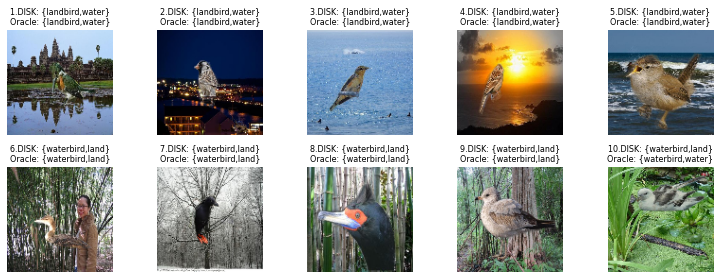

In [100]:
all_indices = random_different_indices_truelabel0  + random_different_indices_truelabel1

def save_images_as_pdf(indices, filename, a=N, b=N, max_images_per_label=N):
    fig = plt.figure(figsize=(13, 12))  # Increase figure size
    label_counter = 0
    label_letter = iter(string.ascii_uppercase)
    
    # domain_labels = ["{landbird,land}","{landbird,water}","{waterbird,water}", "{waterbird,land}"]
    domain_labels = ["{landbird,water}", "{waterbird,land}"]
    current_domain_label = -1
    
    for i, idx in enumerate(indices):
        image_data, label, background_label = train_loader_img_orginal.dataset[idx]
        image_data = np.transpose(image_data, (1, 2, 0))
        
        
        plt.subplot(a, b, i + 1)
        plt.imshow(image_data)
        label_counter += 1
        
        current_letter = domain_labels[current_domain_label]
        
        if i % max_images_per_label == 0:
            current_domain_label += 1
            current_letter = domain_labels[current_domain_label]
        
        
        invariant = "waterbird" if label == 1 else "landbird"
        spurious = "water" if background_label[0] == 1 else "land"
        
        
        plt.title(f"{label_counter}.DISK: {current_letter}\nOracle: {{{invariant},{spurious}}}", fontsize=8)
        plt.axis('off')

    plt.subplots_adjust(wspace=0.2, hspace=0.3)  # Adjust spacing between rows and columns
    plt.savefig(filename, format='pdf')
    plt.show()
    plt.close()

    
    
save_images_as_pdf(all_indices, '/mnority_visualization.pdf')